In [44]:
from Data_manager.UserUtils import *
from Data_manager.split_functions.split_train_validation_random_holdout import \
    split_train_in_two_percentage_global_sample
import numpy as np
np.random.seed(250909)
URM_all = getURM_all()
URM_train_validation, URM_test = split_train_in_two_percentage_global_sample(URM_all, train_percentage = 0.80)
#URM_train, URM_validation = split_train_in_two_percentage_global_sample(URM_train_validation, train_percentage = 0.80)

100%|█████████▉| 22216/22222 [19:14<00:00, 19.25it/s] 


In [45]:
# SETUP EVALUATORS
from Evaluation.Evaluator import EvaluatorHoldout

#evaluator_validation = EvaluatorHoldout(URM_validation, cutoff_list=[10])
evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[10])

EvaluatorHoldout: Ignoring 2105 (16.7%) Users that have less than 1 test interactions


In [46]:
import numpy as np 
import scipy.sparse as sps

profile_length = np.ediff1d(sps.csr_matrix(URM_train_validation).indptr)
profile_length, profile_length.shape

(array([36, 31,  4, ...,  7, 19, 51], dtype=int32), (12638,))

In [36]:
block_size = int(len(profile_length)*0.1)
block_size

1263

In [16]:
sorted_users = np.argsort(profile_length)
for group_id in range(0, 10):
    start_pos = group_id * block_size
    end_pos = min((group_id+1) * block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    

Group 0, #users in group 1263, average p.len 0.85, median 1.0, min 0, max 2
Group 1, #users in group 1263, average p.len 2.43, median 2.0, min 2, max 3
Group 2, #users in group 1263, average p.len 4.73, median 5.0, min 3, max 6
Group 3, #users in group 1263, average p.len 7.66, median 8.0, min 6, max 10
Group 4, #users in group 1263, average p.len 11.82, median 12.0, min 10, max 14
Group 5, #users in group 1263, average p.len 17.55, median 17.0, min 14, max 21
Group 6, #users in group 1263, average p.len 25.77, median 26.0, min 21, max 31
Group 7, #users in group 1263, average p.len 37.68, median 37.0, min 31, max 46
Group 8, #users in group 1263, average p.len 58.74, median 57.0, min 46, max 76
Group 9, #users in group 1263, average p.len 131.98, median 109.0, min 76, max 499


In [47]:
from Hybrid import *
from Recommenders.EASE_R.EASE_R_Recommender import EASE_R_Recommender
from Recommenders.FactorizationMachines.LightFMRecommender import LightFMCFRecommender
from Recommenders.NonPersonalizedRecommender import TopPop
from Recommenders.KNN.UserKNNCFRecommender import UserKNNCFRecommender
from Recommenders.KNN.ItemKNNCFRecommender import ItemKNNCFRecommender
from Recommenders.SLIM.Cython.SLIM_BPR_Cython import SLIM_BPR_Cython
from Recommenders.SLIM.SLIMElasticNetRecommender import *
from Recommenders.GraphBased.P3alphaRecommender import P3alphaRecommender
from Recommenders.GraphBased.RP3betaRecommender import RP3betaRecommender
from Recommenders.MatrixFactorization.Cython.MatrixFactorization_Cython import MatrixFactorization_BPR_Cython, MatrixFactorization_AsySVD_Cython
from Recommenders.MatrixFactorization.PureSVDRecommender import PureSVDRecommender
from Recommenders.MatrixFactorization.IALSRecommender import IALSRecommender
from Recommenders.MatrixFactorization.NMFRecommender import NMFRecommender

MAP_recommender_per_group = {}

collaborative_recommender_class = {"TopPop": TopPop,
                                   "UserKNNCF": UserKNNCFRecommender,
                                   "ItemKNNCF": ItemKNNCFRecommender,
                                   "P3alpha": P3alphaRecommender,
                                   "RP3beta": RP3betaRecommender,
                                   "PureSVD": PureSVDRecommender,
                                   #"NMF": NMFRecommender,
                                   #"MF_BPR": MatrixFactorization_BPR_Cython,
                                   "SLIM_ELASTIC": MultiThreadSLIM_SLIMElasticNetRecommender,
                                   #"SLIM_BPR": SLIM_BPR_Cython,
                                   #"LightFM": LightFMCFRecommender,
                                   #"IALS": IALSRecommender,
                                   #"EASE_R": EASE_R_Recommender,
                                   #"HYBRID": HybridRecommender
                                   }
collaborative_recommender_class.items()

recommender_object_dict = {}

for label, recommender_class in collaborative_recommender_class.items():
    recommender_object = recommender_class(URM_train_validation)
    recommender_object_dict[label] = recommender_object
    
    
recommender_object_dict["TopPop"].fit()
recommender_object_dict["SLIM_ELASTIC"].fit(topK=8894, l1_ratio=0.05565733019999427, alpha=0.0012979360257937668, workers=7)
recommender_object_dict["PureSVD"].fit(num_factors=70, random_seed=42)
#recommender_object_dict["NMF"].load_model("result_experiments/", "NMFRecommender_best_model.zip")
recommender_object_dict["P3alpha"].fit(topK=76, alpha=0.377201600381895, normalize_similarity=True)
recommender_object_dict["RP3beta"].fit(topK=101, alpha=0.3026342852596128, beta=0.058468783118329024)
recommender_object_dict["UserKNNCF"].fit(topK=469, shrink=38, similarity='asymmetric', normalize=True,
                                       feature_weighting='TF-IDF', asymmetric_alpha=0.40077406933762383)
recommender_object_dict["ItemKNNCF"].fit(topK=31, shrink=435, similarity='tversky', normalize=True,
                                       feature_weighting='BM25', tversky_alpha=0.17113169506422393, tversky_beta=0.5684024974085575)
#recommender_object_dict["EASE_R"].fit(topK=24, l2_norm=37.54323189430143)

#recommender_object_dict["MF_BPR"].fit(sgd_mode="adagrad", num_factors=219, batch_size=32, learning_rate=0.08036400470449359,positive_reg=0.016211221706684466,negative_reg=0.00012672106970228173, epochs=260, random_seed=1234)
#recommender_object_dict["SLIM_BPR"].fit(topK=46, symmetric=True, sgd_mode="adagrad", epochs=195, lambda_i=0.00035732097169170193, lambda_j=0.004542391418975173, learning_rate=0.0002291767622519941)
#recommender_object_dict["LightFM"].load_model("result_experiments/", "LightFMCFRecommender_best_model.zip")
#recommender_object_dict["IALS"].fit()
#recommender_object_dict["HYBRID"].fit()
from Hybrid import LinearHybridRecommender
#recommenders = [SLIM_Elastic, RP3Beta, ItemKNNCF, UserKNNCF] # ORDER MATTER!!!!!!!!!

#alphas = [0.6321191861151624, 1.390285841050952, 0.23173069155212617, 0.0031112219228564527]

#recommender_object_dict["HYBRID"] = LinearHybridRecommender(URM_train, recommenders)
#recommender_object_dict["HYBRID"].fit(alphas)

TopPopRecommender: URM Detected 223 ( 1.8%) users with no interactions.
TopPopRecommender: URM Detected 121 ( 0.5%) items with no interactions.
UserKNNCFRecommender: URM Detected 223 ( 1.8%) users with no interactions.
UserKNNCFRecommender: URM Detected 121 ( 0.5%) items with no interactions.
ItemKNNCFRecommender: URM Detected 223 ( 1.8%) users with no interactions.
ItemKNNCFRecommender: URM Detected 121 ( 0.5%) items with no interactions.
P3alphaRecommender: URM Detected 223 ( 1.8%) users with no interactions.
P3alphaRecommender: URM Detected 121 ( 0.5%) items with no interactions.
RP3betaRecommender: URM Detected 223 ( 1.8%) users with no interactions.
RP3betaRecommender: URM Detected 121 ( 0.5%) items with no interactions.
PureSVDRecommender: URM Detected 223 ( 1.8%) users with no interactions.
PureSVDRecommender: URM Detected 121 ( 0.5%) items with no interactions.
SLIMElasticNetRecommender: URM Detected 223 ( 1.8%) users with no interactions.
SLIMElasticNetRecommender: URM Detecte

100%|█████████▉| 22160/22222 [01:58<00:00, 133.88it/s]

PureSVDRecommender: Computing SVD decomposition...
PureSVDRecommender: Computing SVD decomposition... done in 2.63 sec
P3alphaRecommender: Similarity column 22222 (100.0%), 4526.72 column/sec. Elapsed time 4.91 sec
RP3betaRecommender: Similarity column 22222 (100.0%), 3709.43 column/sec. Elapsed time 5.99 sec
Similarity column 12638 (100.0%), 8536.06 column/sec. Elapsed time 1.48 sec


100%|█████████▉| 22216/22222 [02:18<00:00, 133.88it/s]

Similarity column 22222 (100.0%), 7657.49 column/sec. Elapsed time 2.90 sec


In [18]:
# EQUAL SIZE GROUPING
from Evaluation.Evaluator import EvaluatorHoldout

MAP_recommender_per_group = {}
cutoff = 10

for group_id in range(0, 10):
    
    start_pos = group_id*block_size
    end_pos = min((group_id+1)*block_size, len(profile_length))
    
    users_in_group = sorted_users[start_pos:end_pos]
    
    users_in_group_p_len = profile_length[users_in_group]
    
    print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
        group_id, 
        users_in_group.shape[0],
        users_in_group_p_len.mean(),
        np.median(users_in_group_p_len),
        users_in_group_p_len.min(),
        users_in_group_p_len.max()))
    
    
    users_not_in_group_flag = np.isin(sorted_users, users_in_group, invert=True)
    users_not_in_group = sorted_users[users_not_in_group_flag]
    
    evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)
    
    for label, recommender in recommender_object_dict.items():
        result_df, _ = evaluator_test.evaluateRecommender(recommender)
        if label in MAP_recommender_per_group:
            MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
        else:
            MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]


Group 0, #users in group 1263, average p.len 0.85, median 1.0, min 0, max 2
EvaluatorHoldout: Ignoring 2163 (17.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 11375 Users
EvaluatorHoldout: Processed 481 (100.0%) in 0.54 sec. Users per second: 885
EvaluatorHoldout: Processed 481 (100.0%) in 0.65 sec. Users per second: 739
EvaluatorHoldout: Processed 481 (100.0%) in 0.50 sec. Users per second: 963
EvaluatorHoldout: Processed 481 (100.0%) in 0.46 sec. Users per second: 1051
EvaluatorHoldout: Processed 481 (100.0%) in 0.45 sec. Users per second: 1062
EvaluatorHoldout: Processed 481 (100.0%) in 0.52 sec. Users per second: 921
EvaluatorHoldout: Processed 481 (100.0%) in 0.46 sec. Users per second: 1036
Group 1, #users in group 1263, average p.len 2.43, median 2.0, min 2, max 3
EvaluatorHoldout: Ignoring 2163 (17.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 11375 Users
EvaluatorHoldout: Processed 580 (100.0%) in 0.54 sec. Users per

In [42]:
# PROFILE LENGTH BASED GROUPING
from Evaluation.Evaluator import EvaluatorHoldout
import numpy as np

MAP_recommender_per_group = {}
cutoff = 10

# Define the cutoffs for profile length for each group
#profile_length_cutoffs = [2, 4, 6, 8, 25, 40, 65, 130, 200, 1500]
profile_length_cutoffs = [2, 3, 4, 5, 6, 7, 8, 9, 10, 11, 12, 13, 14, 15, 16, 17, 18, 19, 20, 21, 22, 23, 24, 25, 26,
                          27, 28, 29, 30, 32, 34, 36, 38, 40, 42, 44, 46, 48, 50, 60, 80, 100, 200, 1500]

for group_id in range(len(profile_length_cutoffs)):

    # Select users whose profile length is less than the cutoff for the group and greater than or equal to the cutoff for the previous group
    if group_id == 0:
        users_in_group_flag = profile_length < profile_length_cutoffs[group_id]
    else:
        users_in_group_flag = np.logical_and(profile_length >= profile_length_cutoffs[group_id - 1],
                                             profile_length < profile_length_cutoffs[group_id])
    users_in_group = np.arange(len(profile_length))[users_in_group_flag]

    if len(users_in_group) > 0:
        users_in_group_p_len = profile_length[users_in_group]

        print("Group {}, #users in group {}, average p.len {:.2f}, median {}, min {}, max {}".format(
            group_id,
            users_in_group.shape[0],
            users_in_group_p_len.mean(),
            np.median(users_in_group_p_len),
            users_in_group_p_len.min(),
            users_in_group_p_len.max()))

        # Select users not in the current group
        users_not_in_group_flag = np.isin(np.arange(len(profile_length)), users_in_group, invert=True)
        users_not_in_group = np.arange(len(profile_length))[users_not_in_group_flag]

        evaluator_test = EvaluatorHoldout(URM_test, cutoff_list=[cutoff], ignore_users=users_not_in_group)

        for label, recommender in recommender_object_dict.items():
            result_df, _ = evaluator_test.evaluateRecommender(recommender)
            if label in MAP_recommender_per_group:
                MAP_recommender_per_group[label].append(result_df.loc[cutoff]["MAP"])
            else:
                MAP_recommender_per_group[label] = [result_df.loc[cutoff]["MAP"]]
    else:
        print(f"Group {group_id} has no users.")

Group 0, #users in group 1281, average p.len 0.83, median 1.0, min 0, max 1
EvaluatorHoldout: Ignoring 2155 (17.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 11357 Users
EvaluatorHoldout: Processed 518 (100.0%) in 0.62 sec. Users per second: 829
EvaluatorHoldout: Processed 518 (100.0%) in 0.68 sec. Users per second: 765
EvaluatorHoldout: Processed 518 (100.0%) in 0.53 sec. Users per second: 985
EvaluatorHoldout: Processed 518 (100.0%) in 0.50 sec. Users per second: 1027
EvaluatorHoldout: Processed 518 (100.0%) in 0.51 sec. Users per second: 1022
EvaluatorHoldout: Processed 518 (100.0%) in 0.57 sec. Users per second: 903
EvaluatorHoldout: Processed 518 (100.0%) in 0.53 sec. Users per second: 986
Group 1, #users in group 698, average p.len 2.00, median 2.0, min 2, max 2
EvaluatorHoldout: Ignoring 2155 (17.1%) Users that have less than 1 test interactions
EvaluatorHoldout: Ignoring 11940 Users
EvaluatorHoldout: Processed 299 (100.0%) in 0.42 sec. Users per s

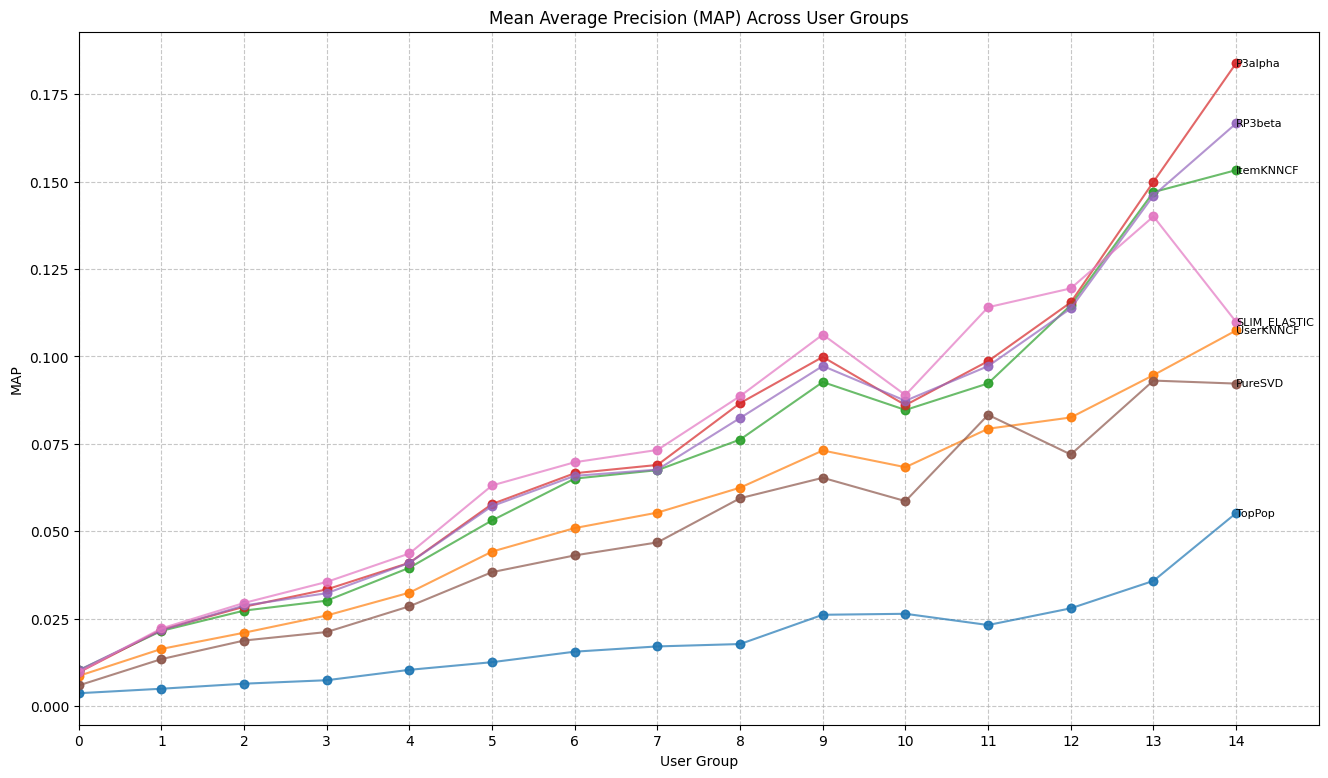

In [18]:
import matplotlib.pyplot as plt
import numpy as np

# Assume you have the following data structure
# recommender_object_dict = {'Recommender1': recommender1, 'Recommender2': recommender2, ...}
# MAP_recommender_per_group = {'Recommender1': [0.8, 0.7, 0.6, ...], 'Recommender2': [0.9, 0.8, 0.7, ...], ...}

# Your original code
_ = plt.figure(figsize=(16, 9))
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.scatter(x=np.arange(0, len(results)), y=results, label=label, alpha=0.7)

# Modifications for a better plot
plt.title('Mean Average Precision (MAP) Across User Groups')
plt.xlabel('User Group')
plt.ylabel('MAP')

# Use a line plot for better trend visualization
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    plt.plot(np.arange(0, len(results)), results, marker='o', linestyle='-', alpha=0.7)
    
    # Annotate the lines with the names of the recommender systems
    last_value = results[-1]
    plt.text(len(results)-1, last_value, label, ha='left', va='center', fontsize=8)

# Add grid for better readability
plt.grid(True, linestyle='--', alpha=0.7)

# Set x-axis ticks to integers from 0 to 4
plt.xticks(np.arange(0, len(results)))

# Set x-axis limits to 0 and 4
plt.xlim(0, len(results))

plt.show()

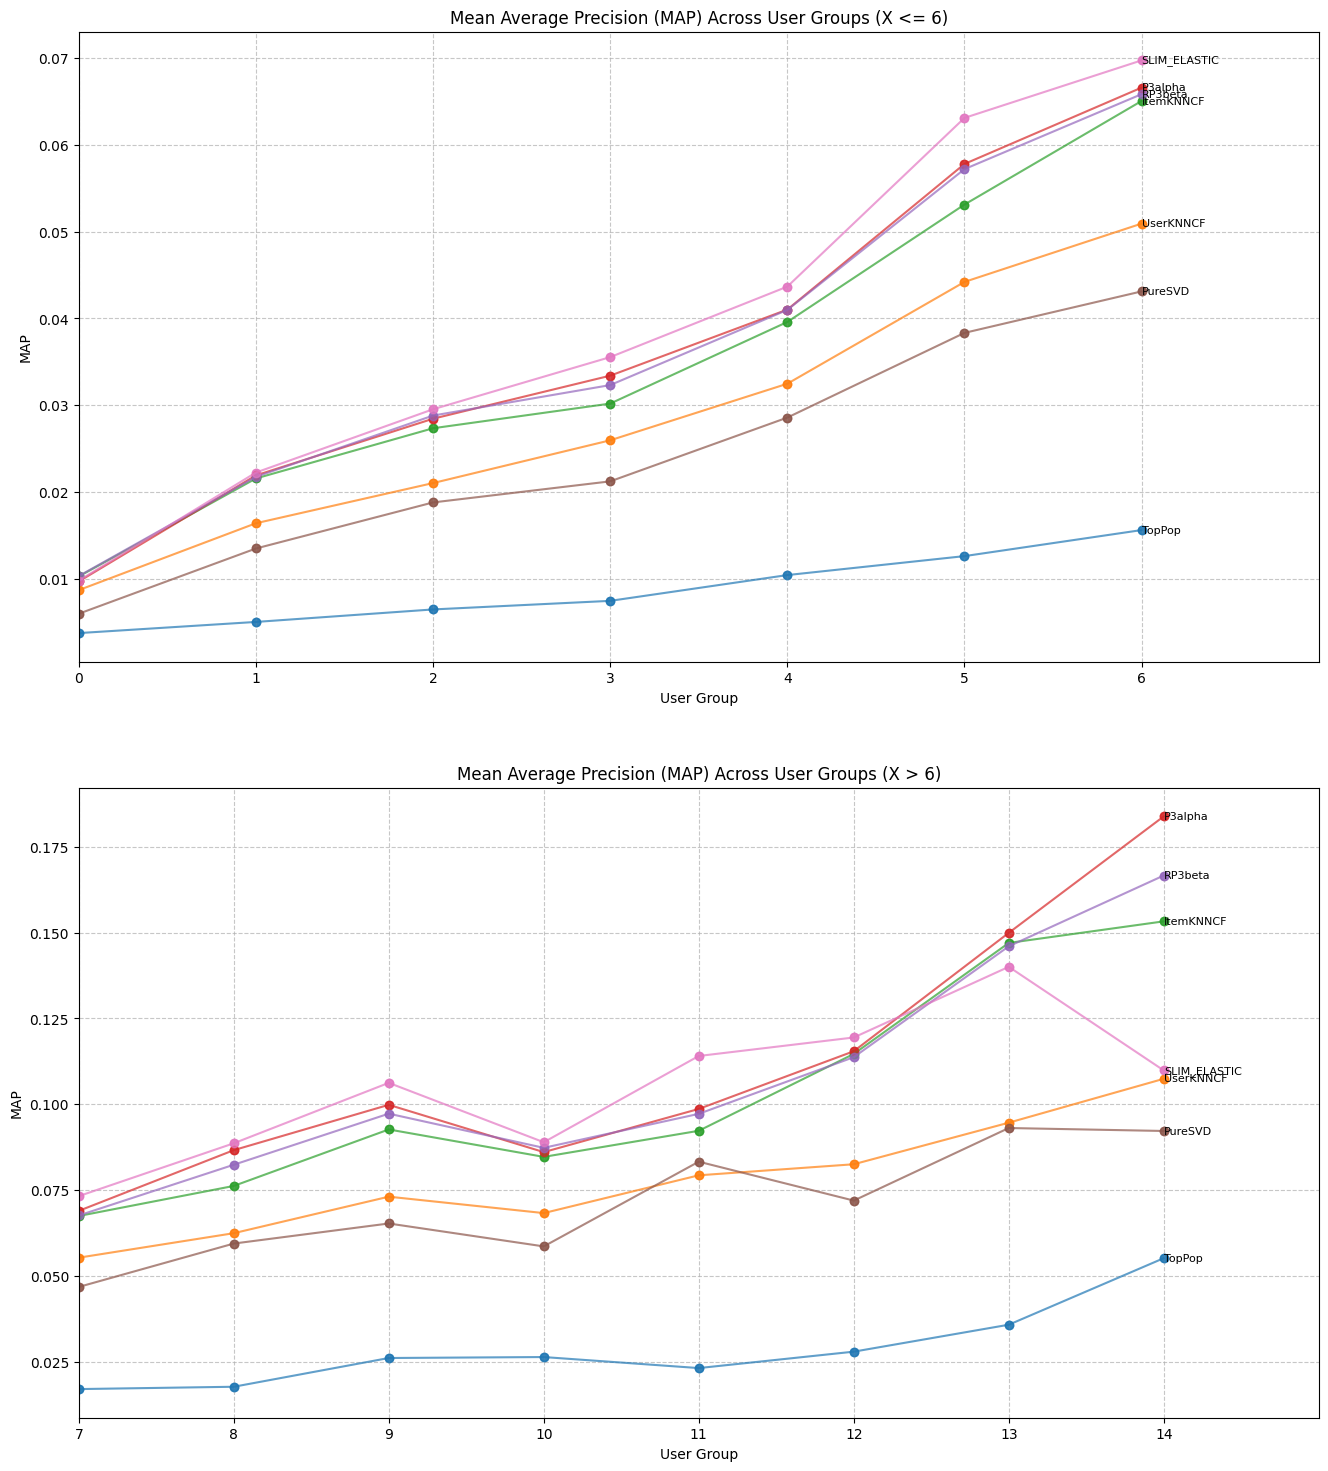

In [19]:
import matplotlib.pyplot as plt
import numpy as np

fig, axs = plt.subplots(2, figsize=(16, 18))

# Plot for X values <= 6
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    results_cutoff = results[:7]  # Get values for X <= 6
    axs[0].scatter(x=np.arange(0, len(results_cutoff)), y=results_cutoff, label=label, alpha=0.7)
    axs[0].plot(np.arange(0, len(results_cutoff)), results_cutoff, marker='o', linestyle='-', alpha=0.7)
    last_value = results_cutoff[-1]
    axs[0].text(len(results_cutoff)-1, last_value, label, ha='left', va='center', fontsize=8)

axs[0].set_title('Mean Average Precision (MAP) Across User Groups (X <= 6)')
axs[0].set_xlabel('User Group')
axs[0].set_ylabel('MAP')
axs[0].grid(True, linestyle='--', alpha=0.7)
axs[0].set_xticks(np.arange(0, len(results_cutoff)))
axs[0].set_xlim(0, len(results_cutoff))

# Plot for X values > 6
for label, recommender in recommender_object_dict.items():
    results = MAP_recommender_per_group[label]
    results_cutoff = results[7:]  # Get values for X > 6
    axs[1].scatter(x=np.arange(7, len(results)), y=results_cutoff, label=label, alpha=0.7)
    axs[1].plot(np.arange(7, len(results)), results_cutoff, marker='o', linestyle='-', alpha=0.7)
    last_value = results_cutoff[-1]
    axs[1].text(len(results)-1, last_value, label, ha='left', va='center', fontsize=8)

axs[1].set_title('Mean Average Precision (MAP) Across User Groups (X > 6)')
axs[1].set_xlabel('User Group')
axs[1].set_ylabel('MAP')
axs[1].grid(True, linestyle='--', alpha=0.7)
axs[1].set_xticks(np.arange(7, len(results)))
axs[1].set_xlim(7, len(results))

plt.show()

In [39]:
import pandas as pd
print(pd.DataFrame(MAP_recommender_per_group))

      TopPop  UserKNNCF  ItemKNNCF   P3alpha   RP3beta   PureSVD  SLIM_ELASTIC
0   0.003459   0.005011   0.004415  0.003911  0.004801  0.001649      0.004188
1   0.003694   0.009647   0.009132  0.009039  0.011309  0.007438      0.009470
2   0.002655   0.009277   0.010641  0.011198  0.012208  0.009620      0.010779
3   0.003151   0.010988   0.012617  0.014004  0.014633  0.010030      0.014475
4   0.004448   0.017134   0.018908  0.020388  0.020224  0.011903      0.021087
5   0.003709   0.013308   0.017299  0.019465  0.019227  0.011236      0.018816
6   0.004546   0.016383   0.019373  0.019604  0.020438  0.012863      0.019412
7   0.005790   0.018955   0.022788  0.022796  0.023833  0.014336      0.022451
8   0.005217   0.019724   0.023095  0.024546  0.024705  0.013123      0.023715
9   0.006493   0.020311   0.018833  0.023182  0.023310  0.014783      0.022925
10  0.005260   0.021144   0.030612  0.031084  0.032577  0.019366      0.031506
11  0.010185   0.022112   0.022613  0.025690  0.0275

In [11]:
df = pd.DataFrame(MAP_recommender_per_group)
df.index[0]

0

In [43]:
#                         0, 1, 2, 3, 4,  5,  6,   7,   8,    9
#profile_length_cutoffs = [2, 4, 6, 8, 25, 50, 80, 100, 250, 1500]
df = pd.DataFrame(MAP_recommender_per_group)
for index, row in df.iterrows():
    sorted_row = row.sort_values(ascending=False)
    max_value = sorted_row.iloc[0]
    max_index = sorted_row.index[0]
    second_max_value = sorted_row.iloc[1]
    second_max_index = sorted_row.index[1]

    # Select users whose profile length is less than the cutoff for the group and greater than or equal to the cutoff for the previous group
    if index == 0:
        users_in_group_flag = np.logical_and(profile_length > 0, profile_length < profile_length_cutoffs[index])
    else:
        users_in_group_flag = np.logical_and(profile_length >= profile_length_cutoffs[index - 1], profile_length < profile_length_cutoffs[index])
    users_in_group = np.arange(len(profile_length))[users_in_group_flag]

    # Calculate the minimum and maximum profile lengths for the users in the group
    min_profile_length = profile_length[users_in_group_flag].min()
    max_profile_length = profile_length[users_in_group_flag].max()

    # Calculate the number of users in the group
    num_users_in_group = len(users_in_group)

    print(f"Row {index}: Max value is {max_value} at {max_index}, Second max value is {second_max_value} at {second_max_index}, Min profile length is {min_profile_length}, Max profile length is {max_profile_length}, Number of users in group is {num_users_in_group}, diff with slim is {max_value - df['SLIM_ELASTIC'][index]}, improvement: {(max_value - df['SLIM_ELASTIC'][index])*num_users_in_group}")

Row 0: Max value is 0.005011108046822333 at UserKNNCF, Second max value is 0.004801280872709445 at RP3beta, Min profile length is 1, Max profile length is 1, Number of users in group is 1061, diff with slim is 0.0008232977875835008, improvement: 0.8735189526260944
Row 1: Max value is 0.011309258374475762 at RP3beta, Second max value is 0.009646705951053774 at UserKNNCF, Min profile length is 2, Max profile length is 2, Number of users in group is 698, diff with slim is 0.001839332165419122, improvement: 1.283853851462547
Row 2: Max value is 0.012208436404864974 at RP3beta, Second max value is 0.011197562358276644 at P3alpha, Min profile length is 3, Max profile length is 3, Number of users in group is 590, diff with slim is 0.0014289579468150897, improvement: 0.8430851886209029
Row 3: Max value is 0.014633342615798744 at RP3beta, Second max value is 0.014475076580339728 at SLIM_ELASTIC, Min profile length is 4, Max profile length is 4, Number of users in group is 522, diff with slim is

In [31]:
# Create an empty DataFrame with the columns you want
df_print = pd.DataFrame(columns=['Row', 'Max Value', 'Max Index', 'Second Max Value', 'Second Max Index', 'Min Profile Length', 'Max Profile Length', 'Number of Users in Group', 'Diff with SLIM', 'Improvement'])

for index, row in df.iterrows():
    sorted_row = row.sort_values(ascending=False)
    max_value = sorted_row.iloc[0]
    max_index = sorted_row.index[0]
    second_max_value = sorted_row.iloc[1]
    second_max_index = sorted_row.index[1]

    # Select users whose profile length is less than the cutoff for the group and greater than or equal to the cutoff for the previous group
    if index == 0:
        users_in_group_flag = np.logical_and(profile_length > 0, profile_length < profile_length_cutoffs[index])
    else:
        users_in_group_flag = np.logical_and(profile_length >= profile_length_cutoffs[index - 1], profile_length < profile_length_cutoffs[index])
    users_in_group = np.arange(len(profile_length))[users_in_group_flag]

    # Calculate the minimum and maximum profile lengths for the users in the group
    min_profile_length = profile_length[users_in_group_flag].min()
    max_profile_length = profile_length[users_in_group_flag].max()

    # Calculate the number of users in the group
    num_users_in_group = len(users_in_group)

    # Calculate the difference with SLIM and the improvement
    diff_with_slim = max_value - df['SLIM_ELASTIC'][index]
    improvement = diff_with_slim * num_users_in_group

    # Add the values to the DataFrame
    df_print = df_print.append({
        'Row': index,
        'Max Value': max_value,
        'Max Index': max_index,
        'Second Max Value': second_max_value,
        'Second Max Index': second_max_index,
        'Min Profile Length': min_profile_length,
        'Max Profile Length': max_profile_length,
        'Number of Users in Group': num_users_in_group,
        'Diff with SLIM': diff_with_slim,
        'Improvement': improvement
    }, ignore_index=True)

# Print the DataFrame
df_print

,Row,Max Value,Max Index,Second Max Value,Second Max Index,Min Profile Length,Max Profile Length,Number of Users in Group,Diff with SLIM,Improvement
0,0,0.002899,TopPop,0.002782,ItemKNNCF,1,1,1038,0.000137,0.141860
1,1,0.010353,UserKNNCF,0.010125,RP3beta,2,2,723,0.001569,1.134091
2,2,0.012208,ItemKNNCF,0.011519,RP3beta,3,3,611,0.001020,0.623346
3,3,0.015080,RP3beta,0.015035,SLIM_ELASTIC,4,4,481,0.000045,0.021841
4,4,0.016718,RP3beta,0.015783,ItemKNNCF,5,5,467,0.001657,0.773672
5,5,0.019064,ItemKNNCF,0.018986,SLIM_ELASTIC,6,6,443,0.000078,0.034658
6,6,0.021862,P3alpha,0.021470,RP3beta,7,7,364,0.000629,0.228877
7,7,0.026343,SLIM_ELASTIC,0.024240,RP3beta,8,8,353,0.000000,0.000000
8,8,0.024286,ItemKNNCF,0.023981,P3alpha,9,9,344,0.001282,0.440980
9,9,0.026790,SLIM_ELASTIC,0.024519,RP3beta,10,10,305,0.000000,0.000000
